Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use industry returns from [Ken French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

2) Forecast (for example) this month's Chemical industry return using last month's returns from all 30 industries 

3) Use LASSO for predictor subset selection over the entire 1960-2016 period to determine that e.g. Beer is predicted by Food, Clothing, Coal

4) Use LASSO-selected predictors and simple linear regression to predict returns

5) Generate portfolios and run backtests.

- Predictor selection - finds same predictors except 2 industries. Possibly use of AICc instead of AIC (don't see an sklearn implementation that uses AICc)

- Prediction by industry - R-squareds line up pretty closely

- Portfolio performance, similar ballpark results. Maybe AICc/AIC; Also paper standardizes predictors, which is pretty standard. Unless I'm missing something, I don't think it should actually matter in this model except maybe numerically speeds convergence. All the inputs are monthly returns so same range. But possibly some difference in methodology there, and I get slightly better results without doing standardization/normalization. Finally, for some reason their mean returns don't line up to geometric mean annualized, they seem to be calculating something different.

- Replicating exactly is hard but it does replicate closely and perform well

- We also try swapping LinearRegression for sklearn neural network MLPRegressor using various NN architectures; enumerate and run all the sklearn regressors.

 

In [165]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from scipy.stats import chisquare, kendalltau
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators

#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from beakerx import *

import plotly as py
# print (py.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


In [166]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


In [167]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


In [168]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

In [169]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

In [170]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

In [171]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

In [172]:
# Run LASSO, then OLS on selected variables

# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [173]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.24%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.52%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.55%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.05%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Running OLS for Books.lead against ['Games', 'Books', 'Coal'

In [174]:
# same predictors selected for all but 2 response vars
# use predictors from paper to match results
if True: # turn off/on
    coef_dict_temp = {}
    coef_dict_temp['Food.lead'] = ['Clths', 'Coal', 'Util', 'Rtail']
    coef_dict_temp['Beer.lead'] = ['Food', 'Clths', 'Coal']
    coef_dict_temp['Smoke.lead'] = ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
    coef_dict_temp['Games.lead'] = ['Books', 'Clths', 'Coal', 'Fin']
    coef_dict_temp['Books.lead'] = ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Hshld.lead'] = ['Clths', 'Coal', 'Rtail']
    coef_dict_temp['Clths.lead'] = ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry',  'Coal', 'Oil', 'Util','Telcm', 'Servs', 'BusEq', 'Rtail']
    # Running OLS for Clths against ['Clths', 'Coal', 'Oil', 'Servs', 'Rtail']
    coef_dict_temp['Hlth.lead'] = ['Books', 'Mines', 'Coal', 'Util']
    coef_dict_temp['Chems.lead'] = ['Clths']
    coef_dict_temp['Txtls.lead'] = ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Cnstr.lead'] = ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
    coef_dict_temp['Steel.lead'] = ['Fin']
    coef_dict_temp['FabPr.lead'] = ['Trans', 'Fin']
    coef_dict_temp['ElcEq.lead'] = ['Fin']
    coef_dict_temp['Autos.lead'] = ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Carry.lead'] = ['Trans']
    coef_dict_temp['Mines.lead'] = []
    coef_dict_temp['Coal.lead'] = ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 'Oil', 'Paper', 'Rtail']
    coef_dict_temp['Oil.lead'] = ['Beer', 'Hlth', 'Carry']
    coef_dict_temp['Util.lead'] = ['Food', 'Beer', 'Smoke', 'Hshld', 'Hlth', 'Cnstr', 'FabPr', 'Carry', 'Mines', 'Oil', 'Util', 'Telcm', 'BusEq', 'Whlsl', 'Fin', 'Other']
    coef_dict_temp['Telcm.lead'] = ['Beer', 'Smoke', 'Books', 'Hshld', 'Cnstr', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
    coef_dict_temp['Servs.lead'] = ['Smoke', 'Books', 'Steel', 'Oil', 'Util', 'Fin']
    coef_dict_temp['BusEq.lead'] = ['Smoke', 'Books', 'Util']
    coef_dict_temp['Paper.lead'] = ['Clths', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Trans.lead'] = ['Fin']
    coef_dict_temp['Whlsl.lead'] = ['Food', 'Beer', 'Smoke', 'Books', 'Hlth', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Fin', 'Other']
    # Running OLS for Whlsl against ['Food', 'Smoke', 'Books', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'Fin', 'Other']
    coef_dict_temp['Rtail.lead'] = ['Rtail']
    coef_dict_temp['Meals.lead'] = ['Smoke', 'Books', 'Clths', 'Steel', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Meals', 'Fin']
    coef_dict_temp['Fin.lead'] = ['Fin']
    coef_dict_temp['Other.lead'] = ['Clths', 'Fin']
    
coef_dict_paper = []
for response in responses:
    print(response, " -> ", coef_dict_temp[response])
    coef_dict_paper.append([predictor_reverse_dict[jstr] for jstr in coef_dict_temp[response]])
print(coef_dict_paper)

Food.lead  ->  ['Clths', 'Coal', 'Util', 'Rtail']
Beer.lead  ->  ['Food', 'Clths', 'Coal']
Smoke.lead  ->  ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Games.lead  ->  ['Books', 'Clths', 'Coal', 'Fin']
Books.lead  ->  ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Hshld.lead  ->  ['Clths', 'Coal', 'Rtail']
Clths.lead  ->  ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
Hlth.lead  ->  ['Books', 'Mines', 'Coal', 'Util']
Chems.lead  ->  ['Clths']
Txtls.lead  ->  ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
Cnstr.lead  ->  ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
Steel.lead  ->  ['Fin']
FabPr.lead  ->  ['Trans', 'Fin']
ElcEq.lead  ->  ['Fin']
Autos.lead  ->  ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
Carry.lead  ->  ['Trans']
Mines.lead  ->  []
Coal.lead  ->  ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 

In [175]:
def predict_with_subsets(X, Y, create_model, coef_dict, verbose=False):
    """evaluate subset selection, pass a model function and subsets, compute avg R-squared"""
    global responses

    nrows, ncols = Y.shape
    model = create_model()
    
    scores = []
    for response_col in range(ncols):
        y = Y[:,response_col]

#        print("LASSO variables selected for %s: " % pred)
#        print(coef_dict[pred])
        
        if not coef_dict[response_col]:
            if verbose:
                print("No coefs selected for " + responses[response_col])
 #           print("---")
            continue
        # fit model vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        #print("Running model for " + pred + " against " + str(coef_dict[pred]))
        # col nums of selected predictors
        predcols = coef_dict[response_col]
        model.fit(X[:, predcols], y)
        y_pred = model.predict(X[:, predcols])
        score = r2_score(y, y_pred)
        scores.append(score)
        if verbose:
            print ("In-sample R-squared: %.2f%% for %s against %s" % (score*100, responses[response_col], 
                                                                      str([predictors[i] for i in coef_dict[response_col]])))
#        print("---")
    
    if verbose:
        print("Mean R-squared: %.2f%%" % (100 * np.mean(np.array(scores))))
    return np.mean(np.array(scores))
    
predict_with_subsets(X, Y, LinearRegression, coef_dict_paper, verbose=True)


In-sample R-squared: 2.24% for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample R-squared: 2.52% for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample R-squared: 6.55% for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample R-squared: 5.05% for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample R-squared: 6.30% for Books.lead against ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
In-sample R-squared: 2.97% for Hshld.lead against ['Clths', 'Coal', 'Rtail']
In-sample R-squared: 7.82% for Clths.lead against ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
In-sample R-squared: 2.68% for Hlth.lead against ['Books', 'Mines', 'Coal', 'Util']
In-sample R-squared: 0.78% for Chems.lead against ['Clths']
In-sample R-squared: 7.91% for Txtls.lead against ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
In

0.03862278631691253

In [176]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))
predict_with_subsets(X, Y, LinearRegression, coef_dict_all, verbose=False)


0.06637486888237353

In [177]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [178]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [179]:
class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("MSE across all predictions: %.4f" % self.mse)
        
        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))
        
        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
        
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        print("Mean return: %.3f%%" % (self.mean_return * 100 ))
        #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
        #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
        print("Monthly Sharpe ratio: %.3f" % (self.sharpe))


In [180]:
NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [181]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [182]:

backtestmodel = BacktestModel(X, Y, create_model=LinearRegression, coef_dict_param=coef_dict_all, startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=False))


[[ -4.70219919  -5.3073358   -3.72029191 -12.42448745  -6.62775756
   -2.90316148  -6.79960146  -2.23172984  -5.75101181  -6.66276641
   -5.75265368  -7.71979359  -6.57864566  -4.32124795  -5.0355927
   -5.92230241  -4.76675177  -1.96315925  -3.43369206  -2.30343164
   -3.72794445  -2.91917105  -5.27753906  -6.40474001  -6.85223288
  -10.16508667  -4.69016977  -8.8042513   -5.4481542   -6.40122815]
 [ -1.09819574   0.33751522   1.47276575  -7.65291563  -0.40550754
   -4.96855817  -1.82873168  -3.4663124   -2.05857985  -0.68158685
   -1.54307573  -2.74859589  -2.04412571  -1.77673237  -3.39612781
   -4.76047089  -0.65055072  -5.08513341   1.95082965  -2.60578312
   -5.09137205  -1.72203771  -3.31591182  -1.94755286  -1.38046013
   -2.75841651  -0.96353404  -6.81674253   1.34059086  -1.59466739]
 [ -1.96144894  -0.87682739  -3.02833064   0.58137733  -0.02056567
    1.67143038  -0.44895783  -1.70395859  -0.63283007  -0.4731534
   -0.71228211  -3.61106494  -1.93572984  -0.64937617  -1.0975

################################################################################.
16:11:38 Still training step 80 of 563
################################################################################.
16:11:39 Still training step 160 of 563
################################################################################.
16:11:40 Still training step 240 of 563
################################################################################.
16:11:41 Still training step 320 of 563
################################################################################.
16:11:41 Still training step 400 of 563
################################################################################.
16:11:42 Still training step 480 of 563
################################################################################.
16:11:44 Still training step 560 of 563
###.
Food: long 93 times, short 37 times, total 130 times
Beer: long 122 times, short 94 times, total 216 times
Smoke: long 211 times, shor

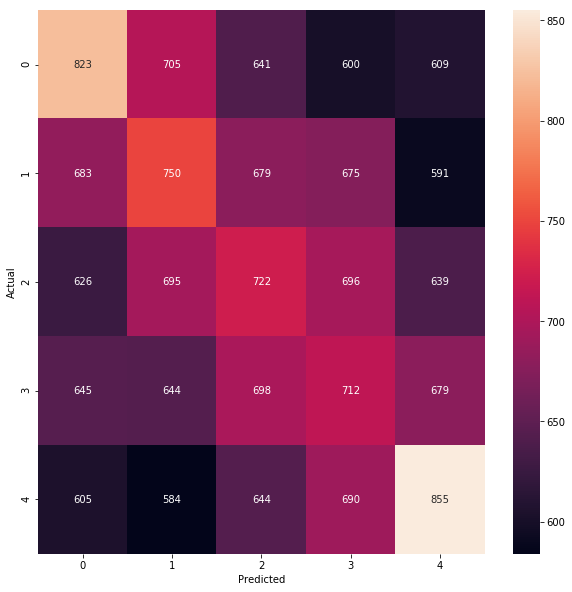

In [183]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param=coef_dict_paper, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)


In [185]:
def mychart(args, names=None, title=""):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].values.reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        title = title,
        autosize=False,
        width=900,
        height=600,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [186]:
perf_post_LASSO = backtestmodel.cumulative_return
mychart([perf_post_LASSO],["Post-LASSO"], title="Post-LASSO")

# bad methodology, introduces snooping
# selects LASSO vars over whole timespan
# uses selected vars to do OLS backtest
# included as an example of what not to do



................................................................................
16:46:33 Still training step 80 of 563
................................................................................
16:46:43 Still training step 160 of 563
................................................................................
16:46:56 Still training step 240 of 563
................................................................................
16:47:11 Still training step 320 of 563
................................................................................
16:47:27 Still training step 400 of 563
................................................................................
16:47:42 Still training step 480 of 563
................................................................................
16:47:57 Still training step 560 of 563
...
Mean return: 3.545%
Monthly Sharpe ratio: 0.674
MSE across all predictions: 41.4734
Variance: 39.4097
R-squared: -0.0524
Avg rank correlation (Kendall

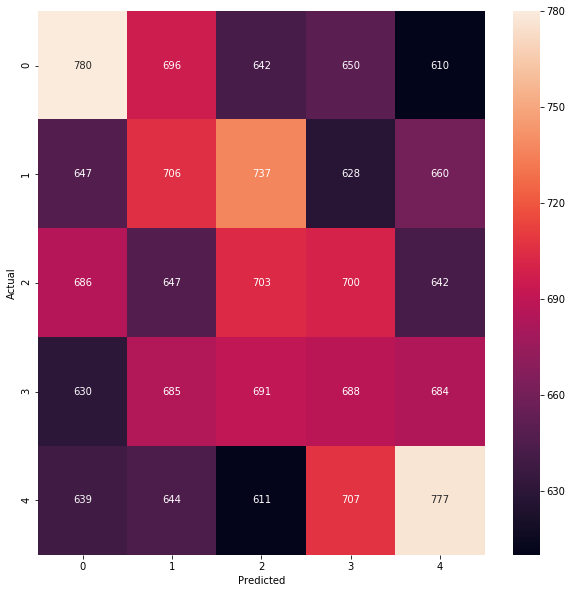

In [191]:
# do LASSO subset selection at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
perf_LASSO_each_timestep = backtestmodel.cumulative_return
mychart([perf_LASSO_each_timestep],["LASSO each timestep"], title="LASSO each timestep")



................................................................................
16:13:58 Still training step 80 of 563
................................................................................
16:14:00 Still training step 160 of 563
................................................................................
16:14:02 Still training step 240 of 563
................................................................................
16:14:05 Still training step 320 of 563
................................................................................
16:14:08 Still training step 400 of 563
................................................................................
16:14:10 Still training step 480 of 563
................................................................................
16:14:13 Still training step 560 of 563
...
Mean return: 2.781%
Monthly Sharpe ratio: 0.506
MSE across all predictions: 43.8692
Variance: 39.4097
R-squared: -0.1132
Avg rank correlation (Kendall

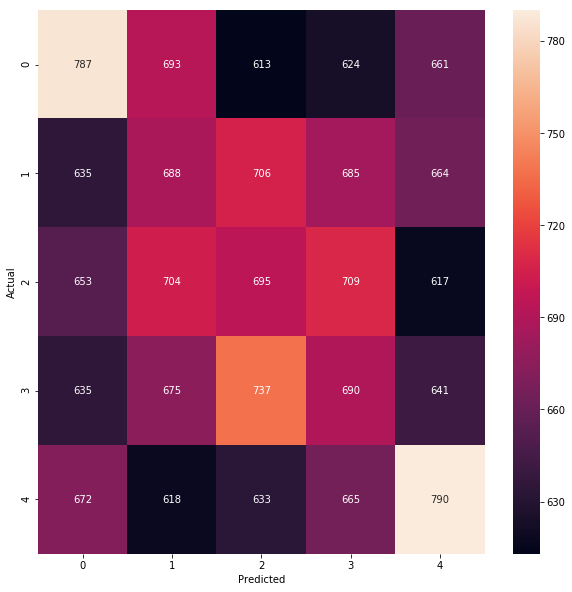

In [188]:
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_all_preds = backtestmodel.cumulative_return
mychart([perf_all_preds],["All preds"], title="OLS all predictors")


................................................................................
16:14:24 Still training step 80 of 563
................................................................................
16:14:33 Still training step 160 of 563
................................................................................
16:14:46 Still training step 240 of 563
................................................................................
16:15:00 Still training step 320 of 563
................................................................................
16:15:14 Still training step 400 of 563
................................................................................
16:15:28 Still training step 480 of 563
................................................................................
16:15:42 Still training step 560 of 563
...
Mean return: 3.077%
Monthly Sharpe ratio: 0.553
MSE across all predictions: 40.0227
Variance: 39.4097
R-squared: -0.0156
Avg rank correlation (Kendall

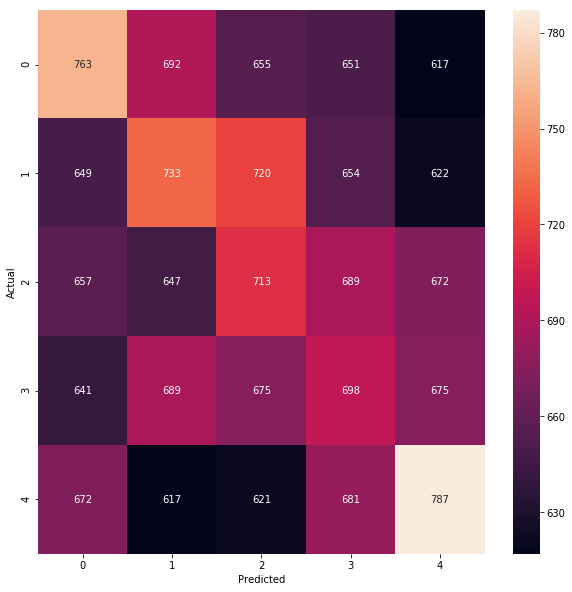

In [189]:
# pure LASSO (not LASSO followed by OLS on selected subset)
def create_model_lasso():
    return LassoLarsIC(criterion='aic')    
    
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model_lasso, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_LASSO_only = backtestmodel.cumulative_return
mychart([perf_LASSO_only],["LASSO only"], title="LASSO only")


In [190]:
mychart([perf_LASSO_each_timestep, perf_all_preds, perf_LASSO_only],["LASSO / OLS", "OLS Only", "LASSO only"])

In [26]:
# walk-forward xval
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)

backtestmodel.walkforward_xval(n_splits=5, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


09:20:39 Generate splits [137, 274, 411, 548, 684]
Steps: [137, 274, 411, 548]
Training on first 137 rows (0:136), putting predictions in rows range(137, 274)
.Training on first 274 rows (0:273), putting predictions in rows range(274, 411)
.Training on first 411 rows (0:410), putting predictions in rows range(411, 548)
.Training on first 548 rows (0:547), putting predictions in rows range(548, 684)
.
Mean return: 2.861%
Monthly Sharpe ratio: 0.575
MSE across all predictions: 41.3994
Variance: 39.6015
R-squared: -0.0454
Avg rank correlation (Kendall's tau): 0.0253 (Expected: 0) Avg p-value 0.4266 (Expected: 0.5)
5-quintile accuracy: 0.2149 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 170.200000


In [133]:
# closure to wrap model creation function - return a function to create model
def create_model(n_hidden_layers, layer_size, reg_penalty):
    def myclosure():
        return MLPRegressor(hidden_layer_sizes=tuple([layer_size]*n_hidden_layers),
                            alpha=reg_penalty,
                            activation='tanh',
                            max_iter=10000, 
                            tol=1e-10,
                            solver='lbfgs')
    return myclosure

# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,2,1.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.walkforward_xval(n_splits=5)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)

# walkforward MSE is worse than walkforward LinearRegression

17:05:07 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.861%
Monthly Sharpe ratio: 0.213
MSE across all predictions: 49.5048
Variance: 39.6015
R-squared: -0.2501
Avg rank correlation (Kendall's tau): 0.0097 (Expected: 0)
5-quintile accuracy: 0.2032 (Expected: 0.2)
Long/short/flat accuracy: 0.4443 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 52.200000


In [136]:
MODELPREFIX = "MLP"

n_hiddens = [1, 2, 3]
layer_sizes = [8, 16, 32]
reg_penalties = [0.0, 0.001, 0.1, 10]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
keys = []
mses = []
sharpes = []
quantile_scores = []
kendalltaus = []
excess_true_positives = []
directional_accuracies = []


for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_model = create_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    experiment_model.gen_returns(calc_returns, verbose=False)
    experiment_model.report_returns(start_date=start_date_str, freq='M')
    experiment_model.evaluate_predictions()
    experiment_model.evaluate_quantiles(chart=False, verbose=False)
    print("---")
    keys.append(key)
    mses.append(experiment_model.mse)
    quantile_scores.append(experiment_model.quintile_accuracy)
    directional_accuracies.append(experiment_model.directional_accuracy)
    kendalltaus.append(experiment_model.kendalltau)
    excess_true_positives.append(experiment_model.excess_tp)
    sharpes.append(experiment_model.sharpe)



23:32:16 Running 36 experiments
23:32:16 Running experiment 1 of 36
23:32:16 n_hidden_layers = 1, hidden_layer_size = 8, reg_penalty = 0.000000
23:32:16 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.767%
Monthly Sharpe ratio: 0.191
MSE across all predictions: 73.7410
Variance: 39.6015
R-squared: -0.8621
Avg rank correlation (Kendall's tau): 0.0098 (Expected: 0)
5-quintile accuracy: 0.2032 (Expected: 0.2)
Long/short/flat accuracy: 0.4445 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 50.200000
---
23:35:03 Running experiment 2 of 36
23:35:03 n_hidden_layers = 1, hidden_layer_size = 8, reg_penalty = 0.001000
23:35:03 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.312%
Monthly Sharpe ratio: -0.041
MSE across all predictions: 75.3377
Variance: 39.6015
R-squared: -0.9024
Avg rank correlation (Kendall's tau): 0.0037 (Expected: 0)
5-quintile accuracy: 0.2035 (Expected: 0.2)
Long/short/flat accuracy: 0.4514 (Expected: 0.44)
Excess true positive in qui

Avg rank correlation (Kendall's tau): 0.0125 (Expected: 0)
5-quintile accuracy: 0.2044 (Expected: 0.2)
Long/short/flat accuracy: 0.4478 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 82.200000
---
01:28:08 Running experiment 18 of 36
01:28:08 n_hidden_layers = 2, hidden_layer_size = 16, reg_penalty = 0.001000
01:28:08 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.741%
Monthly Sharpe ratio: 0.194
MSE across all predictions: 105.9706
Variance: 39.6015
R-squared: -1.6759
Avg rank correlation (Kendall's tau): 0.0101 (Expected: 0)
5-quintile accuracy: 0.2037 (Expected: 0.2)
Long/short/flat accuracy: 0.4461 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 49.200000
---
01:37:37 Running experiment 19 of 36
01:37:37 n_hidden_layers = 2, hidden_layer_size = 16, reg_penalty = 0.100000
01:37:37 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.014%
Monthly Sharpe ratio: 0.017
MSE across all predictions: 94.0320
Variance: 39.6015
R-squared: -1.3745


....
Mean return: 0.792%
Monthly Sharpe ratio: 0.204
MSE across all predictions: 89.0774
Variance: 39.6015
R-squared: -1.2493
Avg rank correlation (Kendall's tau): 0.0038 (Expected: 0)
5-quintile accuracy: 0.2000 (Expected: 0.2)
Long/short/flat accuracy: 0.4427 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 32.200000
---
04:43:53 Running experiment 35 of 36
04:43:53 n_hidden_layers = 3, hidden_layer_size = 32, reg_penalty = 0.100000
04:43:53 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.099%
Monthly Sharpe ratio: 0.251
MSE across all predictions: 94.7429
Variance: 39.6015
R-squared: -1.3924
Avg rank correlation (Kendall's tau): 0.0149 (Expected: 0)
5-quintile accuracy: 0.2166 (Expected: 0.2)
Long/short/flat accuracy: 0.4594 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 133.200000
---
05:20:26 Running experiment 36 of 36
05:20:26 n_hidden_layers = 3, hidden_layer_size = 32, reg_penalty = 10.000000
05:20:26 Generate splits [137, 274, 411, 548, 684]


In [ ]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(keys, mses, sharpes, quantile_scores, directional_accuracies, kendalltaus, excess_true_positives):
    flatlist.append([key[0], key[1], key[2], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
MLPmetricsframe = pd.DataFrame(flatlist, columns = ['layers', 'units', 'reg_penalty',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

MLPmetricsframe.to_csv("MLPmetrics.csv")

In [229]:
metricsframe = pd.read_csv("MLPmetrics.csv")
metricsframe

In [ ]:
metricsframe.sort_values(['mse'])

In [ ]:
metricsframe.sort_values(['sharpe'], ascending=False)

In [ ]:
metricsframe.sort_values(['kendalltau'], ascending=False)

In [ ]:
# show in sortable table widget 
table = TableDisplay(metricsframe)
table.setStringFormatForTimes(TimeUnit.DAYS)
table.setStringFormatForType(ColumnType.Double, TableDisplayStringFormat.getDecimalFormat(4,6))
table.setStringFormatForColumn("m3", TableDisplayStringFormat.getDecimalFormat(0, 0))

table

In [ ]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width="600",
        height="480",
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

sharpes_array=metricsframe["sharpe"].values
mses_array=metricsframe["mse"].values
qscore_array=metricsframe["quantile_score"].values
dscore_array=metricsframe["direction_score"].values
ktscore_array=metricsframe["kendalltau"].values
tpscore_array =metricsframe["truepositive_score"].values
myscatter(sharpes_array, mses_array, title="Sharpe v. MSE")
myscatter(sharpes_array, qscore_array, title="Sharpe v. Quantile Accuracy")
myscatter(sharpes_array, dscore_array, title="Sharpe v. Directional Accuracy")
myscatter(sharpes_array, ktscore_array, title="Sharpe v. Kendall's Tau")
myscatter(sharpes_array, tpscore_array, title="Sharpe v. True Positives")



In [ ]:
metricsframe[['direction_score', 'sharpe', 'mse', 'quantile_score', 'kendalltau', 'truepositive_score']].corr()

In [ ]:
pd.DataFrame(metricsframe.groupby(['layers'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())


In [ ]:
pd.DataFrame(metricsframe.groupby(['units'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())


In [ ]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())


In [ ]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(metricsframe, "layers", "units", x_suffix=" layers", y_suffix=" units")




In [ ]:
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")


In [ ]:
plot_matrix(metricsframe, "reg_penalty", "layers", x_suffix=" p", y_suffix="units")


In [ ]:
def create_model(n_hidden_layers, layer_size, reg_penalty):
    def myclosure():
        return MLPRegressor(hidden_layer_sizes=tuple([layer_size]*n_hidden_layers),
                            alpha=reg_penalty,
                            activation='tanh',
                            max_iter=10000, 
                            tol=1e-10,
                            solver='lbfgs')
    return myclosure

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,1,0.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


................................................................................
05:56:50 Still training step 80 of 563
................................................................................
05:59:31 Still training step 160 of 563
................................................................................
06:03:21 Still training step 240 of 563
................................................................................
06:08:00 Still training step 320 of 563
................................................................................
06:12:23 Still training step 400 of 563
................................................................................
06:16:39 Still training step 480 of 563
................................................................................
06:20:44 Still training step 560 of 563
...
Mean return: 1.621%
Monthly Sharpe ratio: 0.362
MSE across all predictions: 41.2917
Variance: 39.4097
R-squared: -0.0478
Avg rank correlation (Kendall

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,1,0.0), 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


................................................................................
06:22:21 Still training step 80 of 563
................................................................................
06:23:41 Still training step 160 of 563
................................................................................
06:24:49 Still training step 240 of 563
................................................................................
06:25:57 Still training step 320 of 563
................................................................................
06:27:27 Still training step 400 of 563
................................................................................
06:29:01 Still training step 480 of 563
................................................................................
06:30:36 Still training step 560 of 563
...
Mean return: 1.542%
Monthly Sharpe ratio: 0.343
MSE across all predictions: 40.7341
Variance: 39.4097
R-squared: -0.0336
Avg rank correlation (Kendall

In [ ]:
# try all the sklearn regression estimators
estimators = []

for name, class_ in all_estimators():
    if not issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.linear_model.bayes.ARDRegression'>
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>
<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>
<class 'sklearn.ensemble.bagging.BaggingRegressor'>
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
<class 'sklearn.linear_model.bayes.BayesianRidge'>
<class 'sklearn.cluster.birch.Birch'>
<class 'sklearn.cross_decomposition.cca_.CCA'>
<class 'sklearn.mixture.dpgmm.DPGMM'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>
<class 'sklearn.tree.tree.ExtraTreeRegressor'>
<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
<class 'sklearn.mixture.gmm.GMM'>
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
<class 'sklearn.gaussian_process.gaussian_process.GaussianProcess'>
<class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>
<class 'sklearn.ensemble.gr

In [ ]:
estimators = [
    sklearn.ensemble.bagging.BaggingRegressor,
    sklearn.ensemble.forest.ExtraTreesRegressor,
    sklearn.ensemble.forest.RandomForestRegressor,
    sklearn.ensemble.gradient_boosting.GradientBoostingRegressor,
    #sklearn.ensemble.iforest.IsolationForest,
    sklearn.ensemble.weight_boosting.AdaBoostRegressor,
    #sklearn.gaussian_process.gpr.GaussianProcessRegressor,
    sklearn.kernel_ridge.KernelRidge,
    sklearn.linear_model.base.LinearRegression,
    #sklearn.linear_model.bayes.ARDRegression, # takes a couple of hours
    sklearn.linear_model.bayes.BayesianRidge,
    sklearn.linear_model.coordinate_descent.ElasticNet,
    sklearn.linear_model.coordinate_descent.ElasticNetCV,
    sklearn.linear_model.coordinate_descent.Lasso,
    sklearn.linear_model.coordinate_descent.LassoCV,
    sklearn.linear_model.huber.HuberRegressor,
    sklearn.linear_model.least_angle.Lars,
    sklearn.linear_model.least_angle.LarsCV,
    sklearn.linear_model.least_angle.LassoLars,
    sklearn.linear_model.least_angle.LassoLarsCV,
    sklearn.linear_model.least_angle.LassoLarsIC,
    sklearn.linear_model.omp.OrthogonalMatchingPursuit,
    sklearn.linear_model.omp.OrthogonalMatchingPursuitCV,
    sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor,
    sklearn.linear_model.ransac.RANSACRegressor,
    sklearn.linear_model.ridge.Ridge,
    sklearn.linear_model.ridge.RidgeCV,
    sklearn.linear_model.stochastic_gradient.SGDRegressor,
    #sklearn.linear_model.theil_sen.TheilSenRegressor, very slow
    #sklearn.mixture.bayesian_mixture.BayesianGaussianMixture,
    #sklearn.mixture.gaussian_mixture.GaussianMixture,
    sklearn.neighbors.regression.KNeighborsRegressor,
    #sklearn.neighbors.regression.RadiusNeighborsRegressor, returned nan
    #sklearn.neural_network.multilayer_perceptron.MLPRegressor, slow, tried above 
    sklearn.svm.classes.LinearSVR,
    sklearn.svm.classes.NuSVR,
    #sklearn.svm.classes.OneClassSVM,
    sklearn.svm.classes.SVR,
    sklearn.tree.tree.DecisionTreeRegressor,
    sklearn.tree.tree.ExtraTreeRegressor,
    xgboost.XGBRegressor,
]
 

sklearn.ensemble.bagging.BaggingRegressor
................................................................................
06:31:26 Still training step 80 of 563
................................................................................
06:32:33 Still training step 160 of 563
................................................................................
06:34:02 Still training step 240 of 563
................................................................................
06:35:57 Still training step 320 of 563
................................................................................
06:38:22 Still training step 400 of 563
................................................................................
06:41:19 Still training step 480 of 563
................................................................................
06:44:58 Still training step 560 of 563
...
Mean return: 2.383%
Monthly Sharpe ratio: 0.499
MSE across all predictions: 45.8151
Variance: 39.4097
R-squa

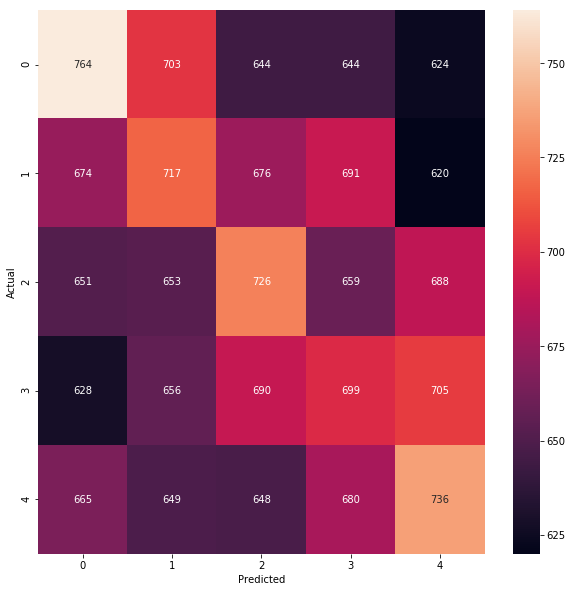

---
sklearn.ensemble.forest.ExtraTreesRegressor
................................................................................
06:45:40 Still training step 80 of 563
................................................................................
06:46:20 Still training step 160 of 563
................................................................................
06:47:08 Still training step 240 of 563
................................................................................
06:48:04 Still training step 320 of 563
................................................................................
06:49:09 Still training step 400 of 563
................................................................................
06:50:24 Still training step 480 of 563
................................................................................
06:51:49 Still training step 560 of 563
...
Mean return: 1.915%
Monthly Sharpe ratio: 0.418
MSE across all predictions: 46.7510
Variance: 39.4097


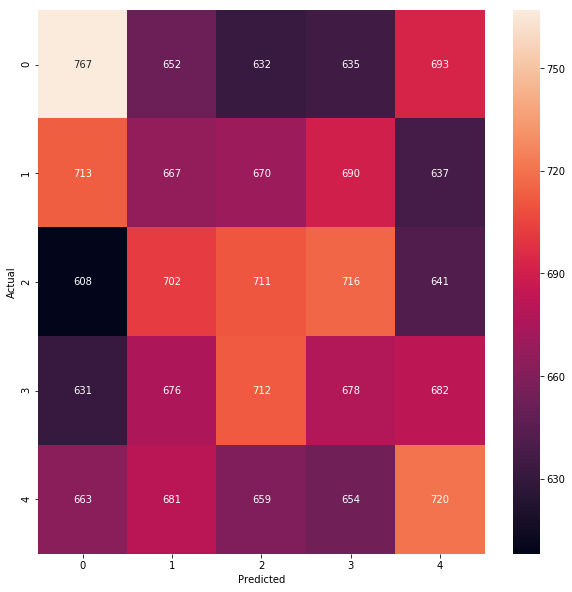

---
sklearn.ensemble.forest.RandomForestRegressor
................................................................................
06:52:40 Still training step 80 of 563
................................................................................
06:53:47 Still training step 160 of 563
................................................................................
06:55:16 Still training step 240 of 563
................................................................................
06:57:09 Still training step 320 of 563
................................................................................
06:59:34 Still training step 400 of 563
................................................................................
07:02:30 Still training step 480 of 563
................................................................................
07:06:08 Still training step 560 of 563
...
Mean return: 1.516%
Monthly Sharpe ratio: 0.340
MSE across all predictions: 46.3802
Variance: 39.409

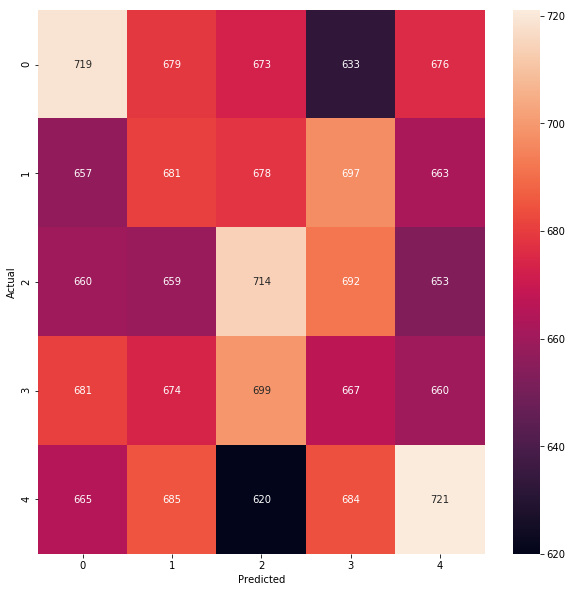

---
sklearn.ensemble.gradient_boosting.GradientBoostingRegressor
................................................................................
07:07:42 Still training step 80 of 563
................................................................................
07:09:36 Still training step 160 of 563
................................................................................
07:11:57 Still training step 240 of 563
................................................................................
07:14:43 Still training step 320 of 563
................................................................................
07:17:57 Still training step 400 of 563
................................................................................
07:21:39 Still training step 480 of 563
................................................................................
07:25:48 Still training step 560 of 563
...
Mean return: 2.349%
Monthly Sharpe ratio: 0.499
MSE across all predictions: 46.7656
V

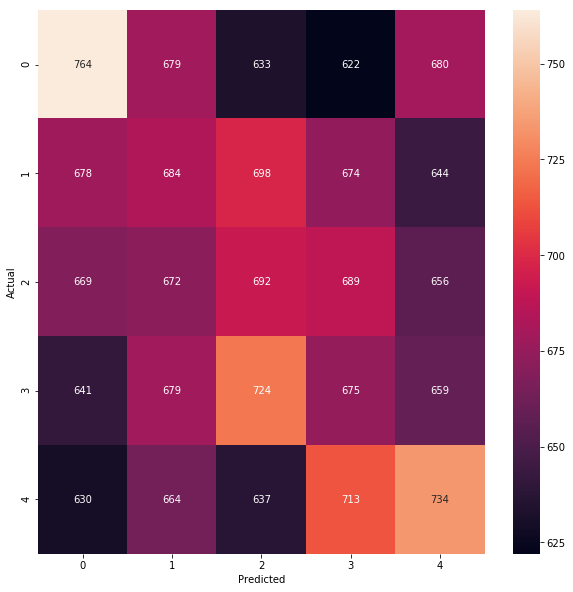

---
sklearn.ensemble.weight_boosting.AdaBoostRegressor
................................................................................
07:28:37 Still training step 80 of 563
................................................................................
07:31:42 Still training step 160 of 563
................................................................................
07:35:17 Still training step 240 of 563
................................................................................
07:39:19 Still training step 320 of 563
................................................................................
07:43:50 Still training step 400 of 563
................................................................................
07:48:48 Still training step 480 of 563
................................................................................
07:54:08 Still training step 560 of 563
...
Mean return: 2.494%
Monthly Sharpe ratio: 0.504
MSE across all predictions: 42.8157
Variance: 3

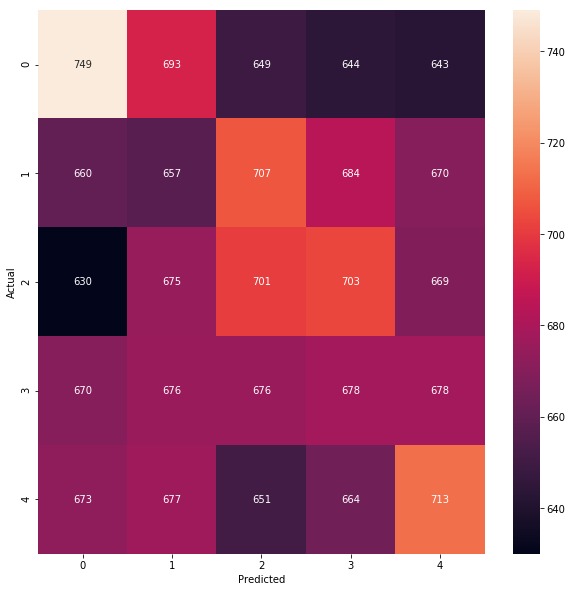

---
sklearn.kernel_ridge.KernelRidge
................................................................................
07:54:25 Still training step 80 of 563
................................................................................
07:54:28 Still training step 160 of 563
................................................................................
07:54:34 Still training step 240 of 563
................................................................................
07:54:42 Still training step 320 of 563
................................................................................
07:54:53 Still training step 400 of 563
................................................................................
07:55:08 Still training step 480 of 563
................................................................................
07:55:27 Still training step 560 of 563
...
Mean return: 2.553%
Monthly Sharpe ratio: 0.471
MSE across all predictions: 44.0938
Variance: 39.4097
R-squared: 

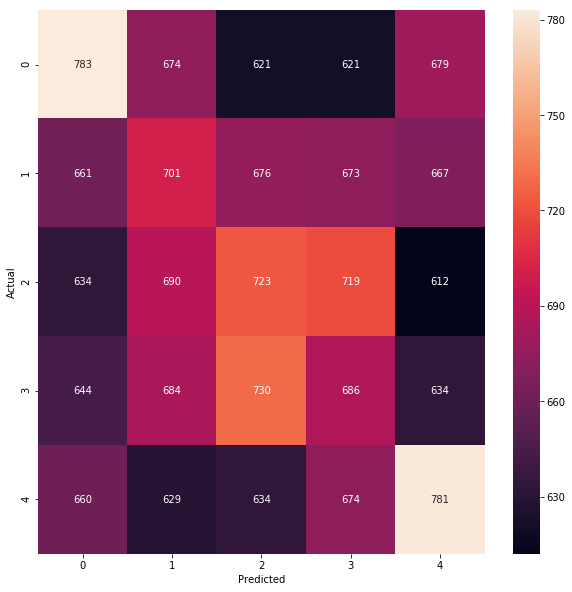

---
sklearn.linear_model.base.LinearRegression
................................................................................
07:55:30 Still training step 80 of 563
................................................................................
07:55:32 Still training step 160 of 563
................................................................................
07:55:34 Still training step 240 of 563
................................................................................
07:55:37 Still training step 320 of 563
................................................................................
07:55:39 Still training step 400 of 563
................................................................................
07:55:42 Still training step 480 of 563
................................................................................
07:55:45 Still training step 560 of 563
...
Mean return: 2.781%
Monthly Sharpe ratio: 0.506
MSE across all predictions: 43.8692
Variance: 39.4097
R

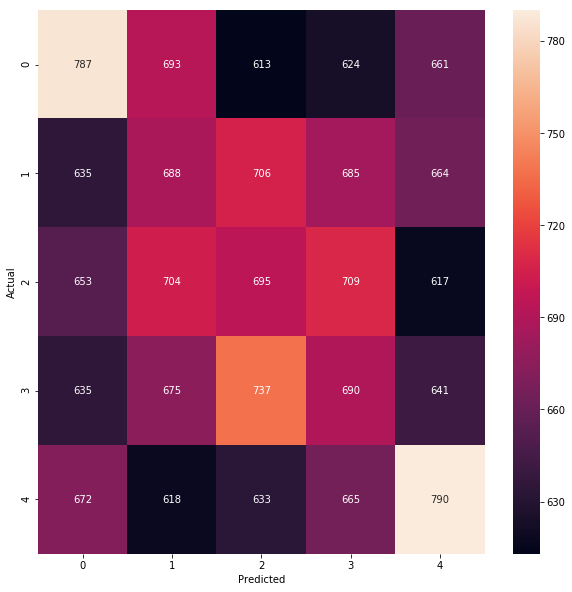

---
sklearn.linear_model.bayes.BayesianRidge
................................................................................
07:55:49 Still training step 80 of 563
................................................................................
07:55:52 Still training step 160 of 563
................................................................................
07:55:58 Still training step 240 of 563
................................................................................
07:56:03 Still training step 320 of 563
................................................................................
07:56:09 Still training step 400 of 563
................................................................................
07:56:16 Still training step 480 of 563
................................................................................
07:56:23 Still training step 560 of 563
...
Mean return: 3.688%
Monthly Sharpe ratio: 0.617
MSE across all predictions: 39.7450
Variance: 39.4097
R-s

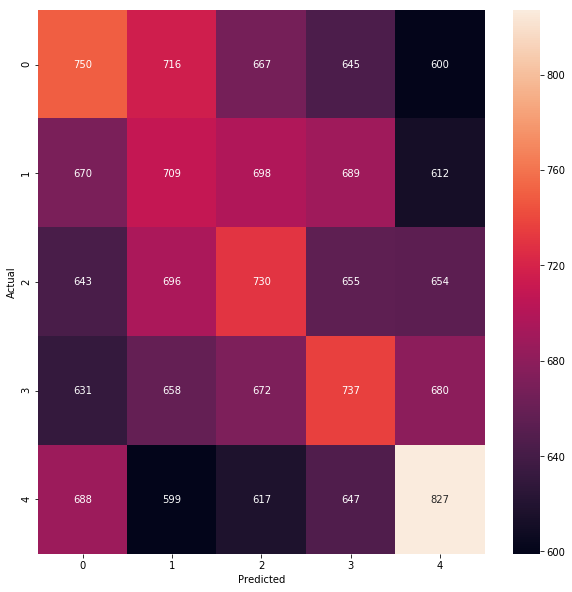

---
sklearn.linear_model.coordinate_descent.ElasticNet
................................................................................
07:56:26 Still training step 80 of 563
................................................................................
07:56:28 Still training step 160 of 563
................................................................................
07:56:29 Still training step 240 of 563
................................................................................
07:56:31 Still training step 320 of 563
................................................................................
07:56:33 Still training step 400 of 563
................................................................................
07:56:36 Still training step 480 of 563
................................................................................
07:56:38 Still training step 560 of 563
...
Mean return: 3.145%
Monthly Sharpe ratio: 0.530
MSE across all predictions: 40.8226
Variance: 3

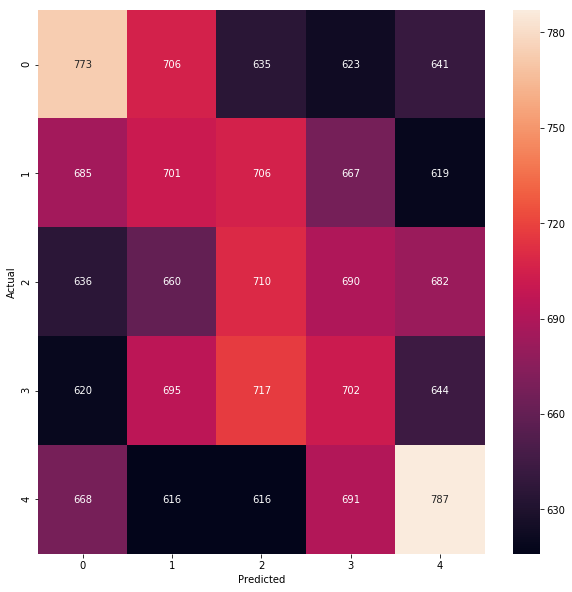

---
sklearn.linear_model.coordinate_descent.ElasticNetCV
................................................................................
07:58:49 Still training step 80 of 563
................................................................................
08:00:44 Still training step 160 of 563
................................................................................
08:02:51 Still training step 240 of 563
................................................................................
08:04:49 Still training step 320 of 563
................................................................................
08:06:59 Still training step 400 of 563
................................................................................
08:08:58 Still training step 480 of 563
................................................................................
08:10:59 Still training step 560 of 563
...
Mean return: 3.551%
Monthly Sharpe ratio: 0.632
MSE across all predictions: 39.8834
Variance:

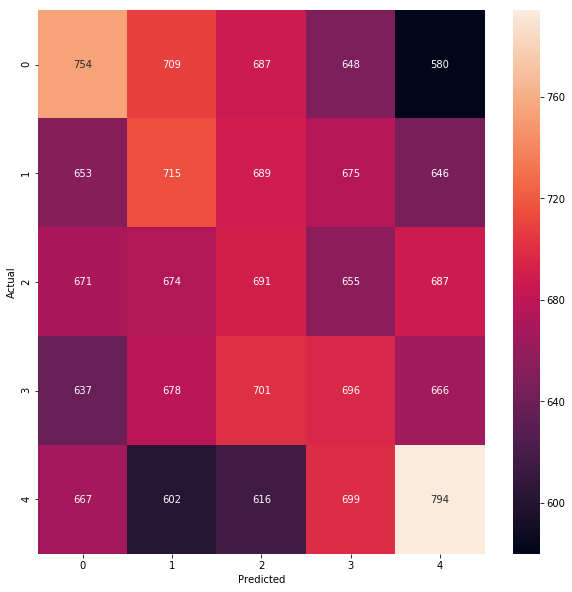

---
sklearn.linear_model.coordinate_descent.Lasso
................................................................................
08:11:06 Still training step 80 of 563
................................................................................
08:11:07 Still training step 160 of 563
................................................................................
08:11:08 Still training step 240 of 563
................................................................................
08:11:10 Still training step 320 of 563
................................................................................
08:11:11 Still training step 400 of 563
................................................................................
08:11:12 Still training step 480 of 563
................................................................................
08:11:14 Still training step 560 of 563
...
Mean return: 3.739%
Monthly Sharpe ratio: 0.639
MSE across all predictions: 40.1141
Variance: 39.409

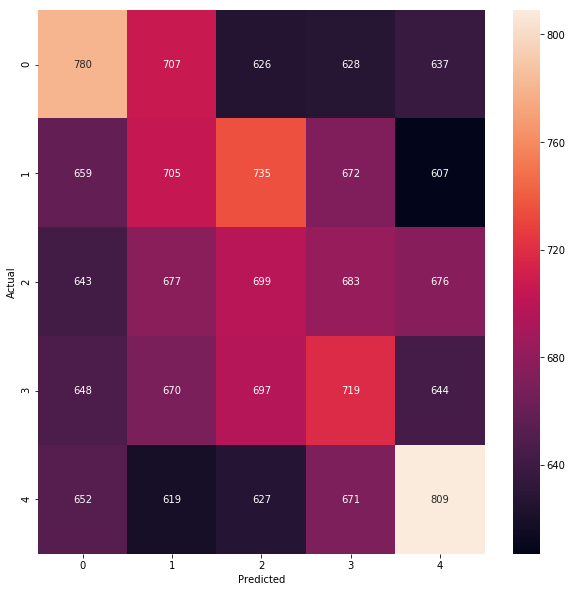

---
sklearn.linear_model.coordinate_descent.LassoCV
................................................................................
08:13:19 Still training step 80 of 563
................................................................................
08:15:10 Still training step 160 of 563
................................................................................
08:17:07 Still training step 240 of 563
................................................................................
08:18:50 Still training step 320 of 563
................................................................................
08:20:54 Still training step 400 of 563
................................................................................
08:22:52 Still training step 480 of 563
................................................................................
08:24:51 Still training step 560 of 563
...
Mean return: 3.323%
Monthly Sharpe ratio: 0.587
MSE across all predictions: 39.9025
Variance: 39.4

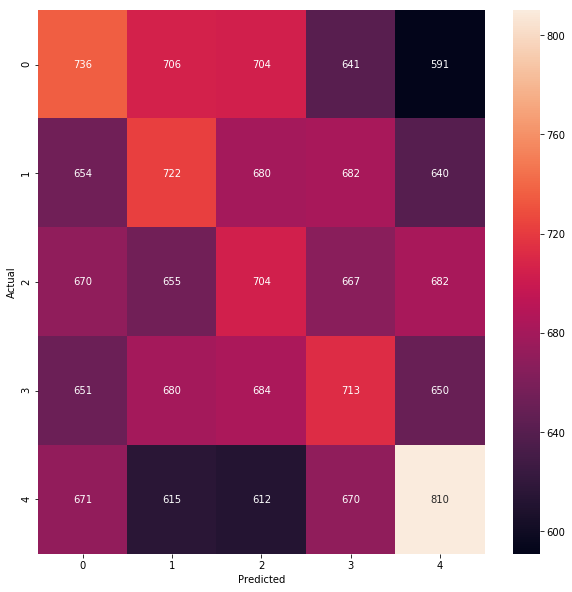

---
sklearn.linear_model.huber.HuberRegressor
................................................................................
08:25:17 Still training step 80 of 563
................................................................................
08:25:38 Still training step 160 of 563
................................................................................
08:26:07 Still training step 240 of 563
................................................................................
08:26:40 Still training step 320 of 563
................................................................................
08:27:15 Still training step 400 of 563
................................................................................
08:27:50 Still training step 480 of 563
................................................................................
08:28:28 Still training step 560 of 563
...
Mean return: 1.166%
Monthly Sharpe ratio: 0.237
MSE across all predictions: 43.6486
Variance: 39.4097
R-

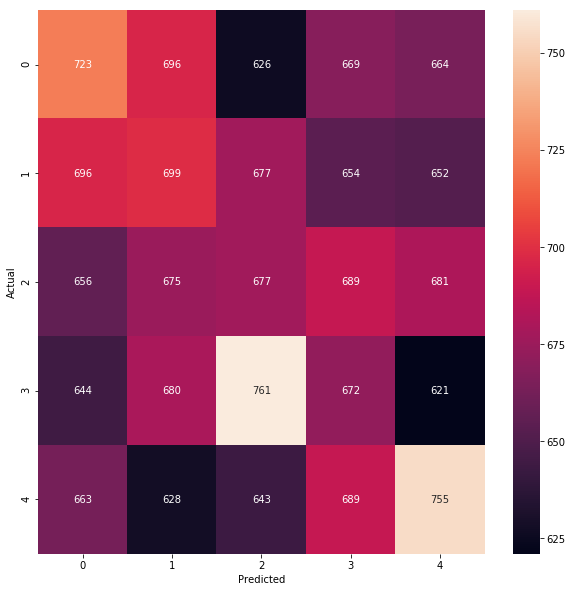

---
sklearn.linear_model.least_angle.Lars
................................................................................
08:28:39 Still training step 80 of 563
................................................................................
08:28:47 Still training step 160 of 563
................................................................................
08:28:58 Still training step 240 of 563
................................................................................
08:29:08 Still training step 320 of 563
................................................................................
08:29:19 Still training step 400 of 563
................................................................................
08:29:31 Still training step 480 of 563
................................................................................
08:29:42 Still training step 560 of 563
...
Mean return: 2.210%
Monthly Sharpe ratio: 0.414
MSE across all predictions: 44.4498
Variance: 39.4097
R-squa

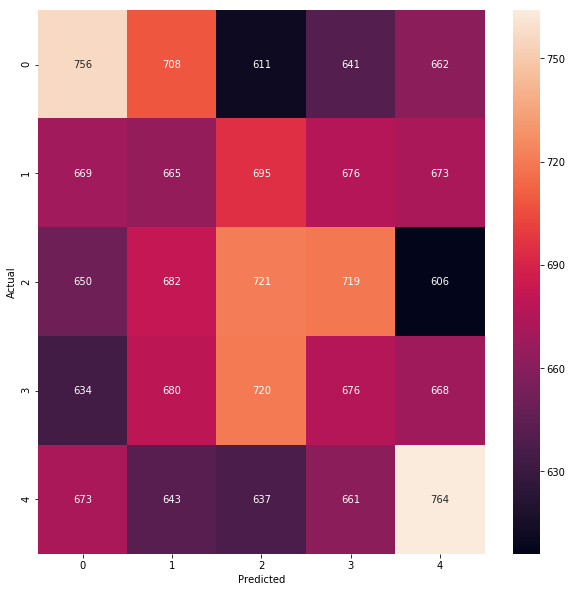

---
sklearn.linear_model.least_angle.LarsCV
................................................................................
08:30:10 Still training step 80 of 563
................................................................................
08:30:37 Still training step 160 of 563
................................................................................
08:31:09 Still training step 240 of 563
................................................................................
08:31:44 Still training step 320 of 563
................................................................................
08:32:27 Still training step 400 of 563
................................................................................
08:33:10 Still training step 480 of 563
................................................................................
08:33:53 Still training step 560 of 563
...
Mean return: 2.888%
Monthly Sharpe ratio: 0.555
MSE across all predictions: 39.8423
Variance: 39.4097
R-sq

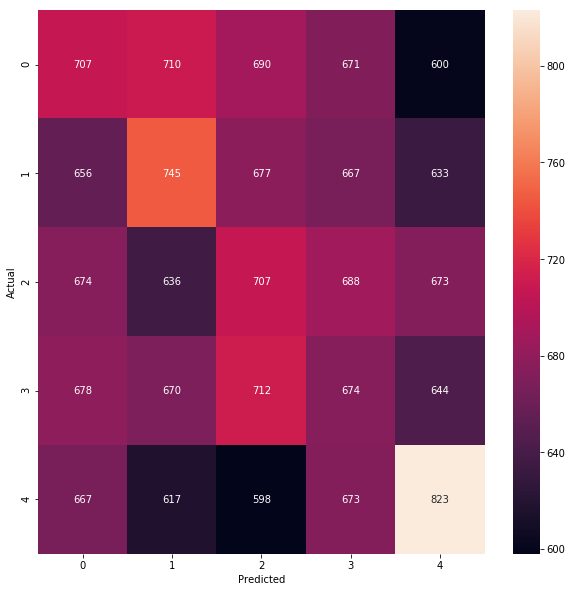

---
sklearn.linear_model.least_angle.LassoLars
................................................................................
08:33:57 Still training step 80 of 563
................................................................................
08:33:58 Still training step 160 of 563
................................................................................
08:33:59 Still training step 240 of 563
................................................................................
08:34:00 Still training step 320 of 563
................................................................................
08:34:02 Still training step 400 of 563
................................................................................
08:34:03 Still training step 480 of 563
................................................................................
08:34:05 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
MSE across all predictions: 39.8418
Variance: 39.4097

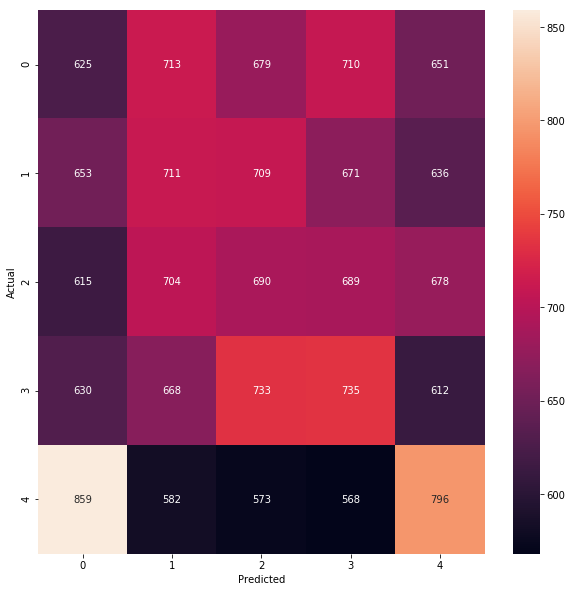

---
sklearn.linear_model.least_angle.LassoLarsCV
................................................................................
08:34:33 Still training step 80 of 563
................................................................................
08:35:01 Still training step 160 of 563
................................................................................
08:35:35 Still training step 240 of 563
................................................................................
08:36:16 Still training step 320 of 563
................................................................................
08:36:59 Still training step 400 of 563
................................................................................
08:37:42 Still training step 480 of 563
................................................................................
08:38:26 Still training step 560 of 563
...
Mean return: 3.084%
Monthly Sharpe ratio: 0.594
MSE across all predictions: 39.8093
Variance: 39.4097

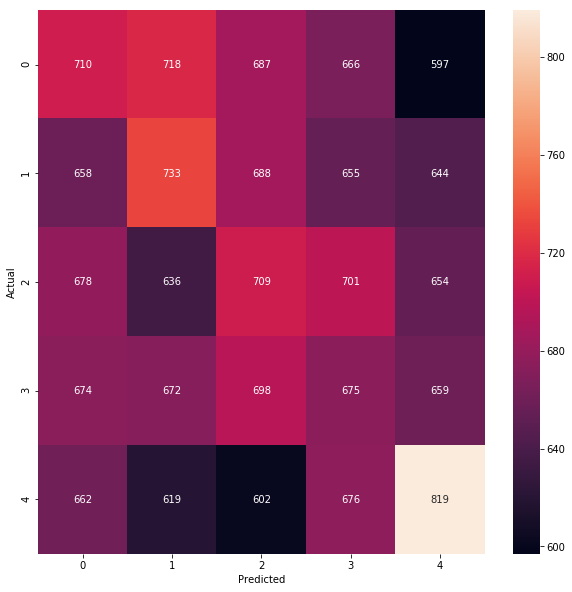

---
sklearn.linear_model.least_angle.LassoLarsIC
................................................................................
08:38:38 Still training step 80 of 563
................................................................................
08:38:47 Still training step 160 of 563
................................................................................
08:39:00 Still training step 240 of 563
................................................................................
08:39:14 Still training step 320 of 563
................................................................................
08:39:28 Still training step 400 of 563
................................................................................
08:39:42 Still training step 480 of 563
................................................................................
08:39:55 Still training step 560 of 563
...
Mean return: 3.077%
Monthly Sharpe ratio: 0.553
MSE across all predictions: 40.0227
Variance: 39.4097

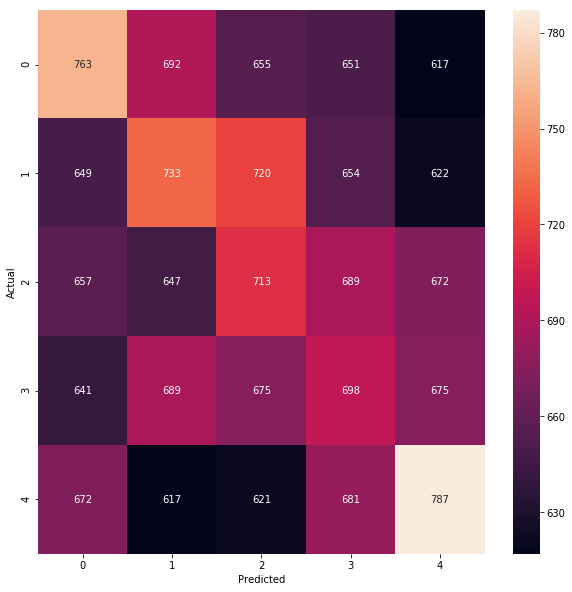

---
sklearn.linear_model.omp.OrthogonalMatchingPursuit
................................................................................
08:39:58 Still training step 80 of 563
................................................................................
08:40:00 Still training step 160 of 563
................................................................................
08:40:01 Still training step 240 of 563
................................................................................
08:40:03 Still training step 320 of 563
................................................................................
08:40:05 Still training step 400 of 563
................................................................................
08:40:07 Still training step 480 of 563
................................................................................
08:40:09 Still training step 560 of 563
...
Mean return: 3.374%
Monthly Sharpe ratio: 0.635
MSE across all predictions: 40.8778
Variance: 3

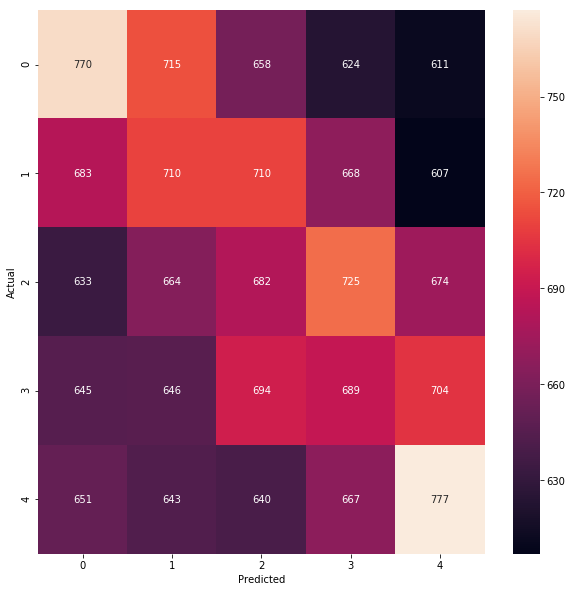

---
sklearn.linear_model.omp.OrthogonalMatchingPursuitCV
................................................................................
08:40:15 Still training step 80 of 563
................................................................................
08:40:21 Still training step 160 of 563
................................................................................
08:40:27 Still training step 240 of 563
................................................................................
08:40:35 Still training step 320 of 563
................................................................................
08:40:43 Still training step 400 of 563
................................................................................
08:40:52 Still training step 480 of 563
................................................................................
08:41:00 Still training step 560 of 563
...
Mean return: 2.559%
Monthly Sharpe ratio: 0.485
MSE across all predictions: 40.2359
Variance:

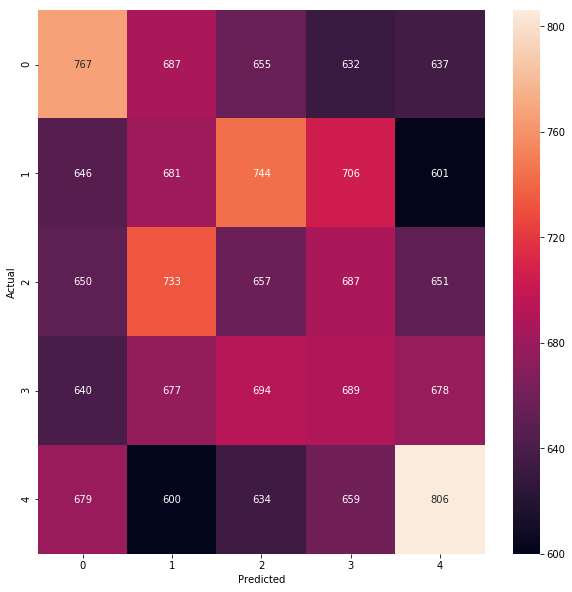

---
sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor
................................................................................
08:41:02 Still training step 80 of 563
................................................................................
08:41:03 Still training step 160 of 563
................................................................................
08:41:04 Still training step 240 of 563
................................................................................
08:41:06 Still training step 320 of 563
................................................................................
08:41:07 Still training step 400 of 563
................................................................................
08:41:08 Still training step 480 of 563
................................................................................
08:41:10 Still training step 560 of 563
...
Mean return: 0.298%
Monthly Sharpe ratio: 0.090
MSE across all predictions: 117

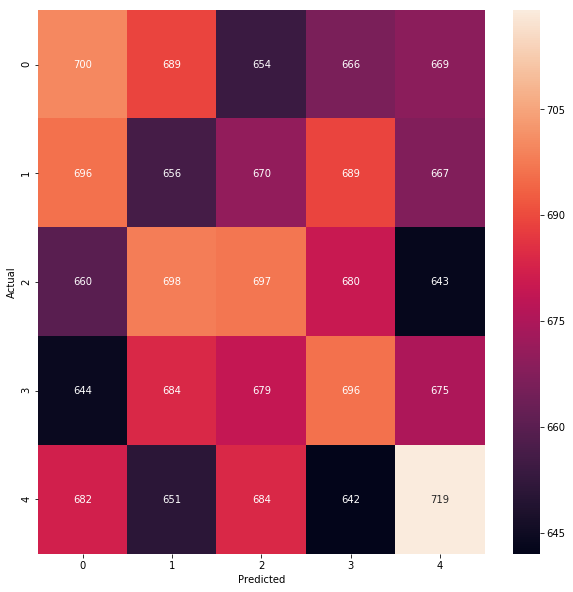

---
sklearn.linear_model.ransac.RANSACRegressor
................................................................................
08:43:10 Still training step 80 of 563
................................................................................
08:45:10 Still training step 160 of 563
................................................................................
08:47:51 Still training step 240 of 563
................................................................................
08:50:53 Still training step 320 of 563
................................................................................
08:53:58 Still training step 400 of 563
................................................................................
08:57:04 Still training step 480 of 563
................................................................................
09:00:11 Still training step 560 of 563
...
Mean return: 0.651%
Monthly Sharpe ratio: 0.174
MSE across all predictions: 207.3074
Variance: 39.4097

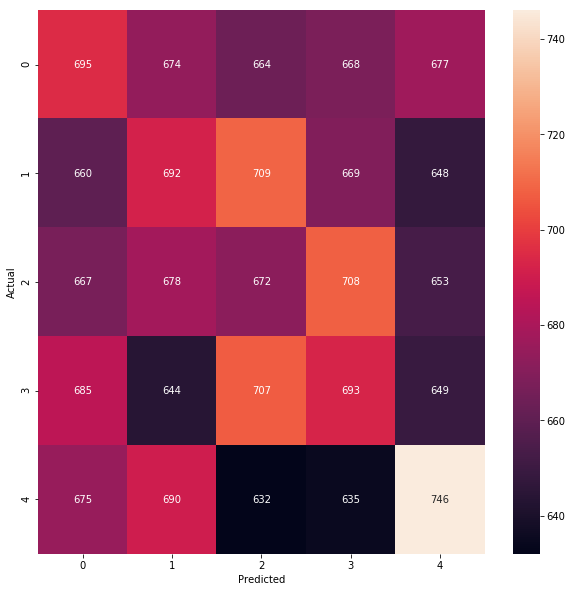

---
sklearn.linear_model.ridge.Ridge
................................................................................
09:00:20 Still training step 80 of 563
................................................................................
09:00:21 Still training step 160 of 563
................................................................................
09:00:22 Still training step 240 of 563
................................................................................
09:00:24 Still training step 320 of 563
................................................................................
09:00:25 Still training step 400 of 563
................................................................................
09:00:27 Still training step 480 of 563
................................................................................
09:00:28 Still training step 560 of 563
...
Mean return: 2.772%
Monthly Sharpe ratio: 0.504
MSE across all predictions: 43.8617
Variance: 39.4097
R-squared: 

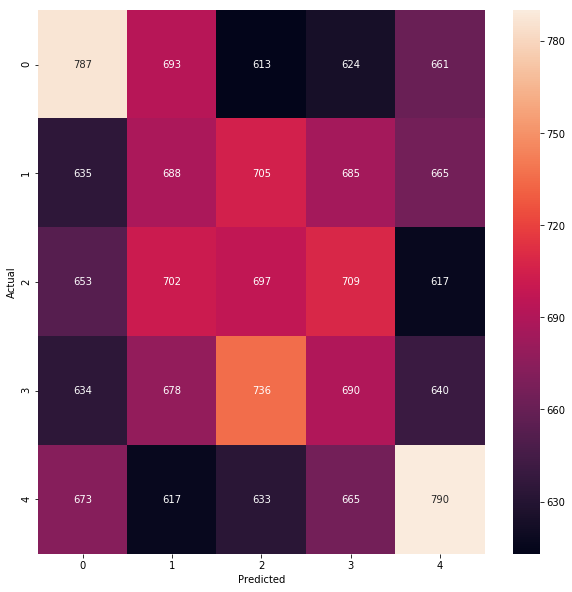

---
sklearn.linear_model.ridge.RidgeCV
................................................................................
09:00:32 Still training step 80 of 563
................................................................................
09:00:34 Still training step 160 of 563
................................................................................
09:00:38 Still training step 240 of 563
................................................................................
09:00:43 Still training step 320 of 563
................................................................................
09:00:48 Still training step 400 of 563
................................................................................
09:00:53 Still training step 480 of 563
................................................................................
09:00:59 Still training step 560 of 563
...
Mean return: 2.762%
Monthly Sharpe ratio: 0.502
MSE across all predictions: 43.7969
Variance: 39.4097
R-squared

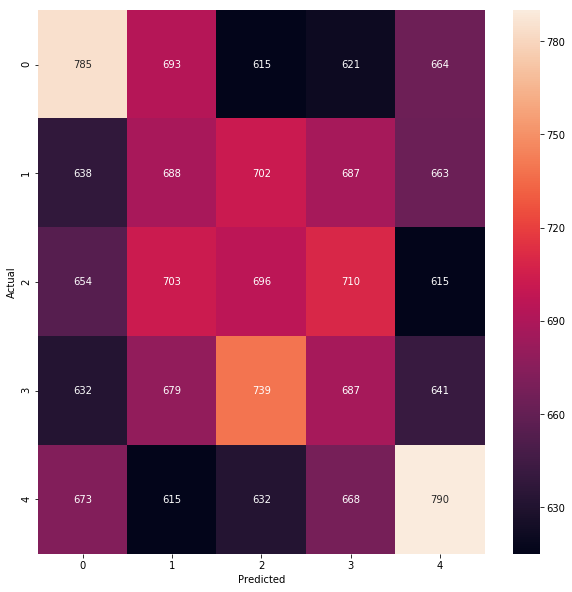

---
sklearn.linear_model.stochastic_gradient.SGDRegressor
................................................................................
09:01:01 Still training step 80 of 563
................................................................................
09:01:02 Still training step 160 of 563
................................................................................
09:01:03 Still training step 240 of 563
................................................................................
09:01:04 Still training step 320 of 563
................................................................................
09:01:06 Still training step 400 of 563
................................................................................
09:01:07 Still training step 480 of 563
................................................................................
09:01:09 Still training step 560 of 563
...
Mean return: -0.157%
Monthly Sharpe ratio: -0.018
MSE across all predictions: 56625489652576

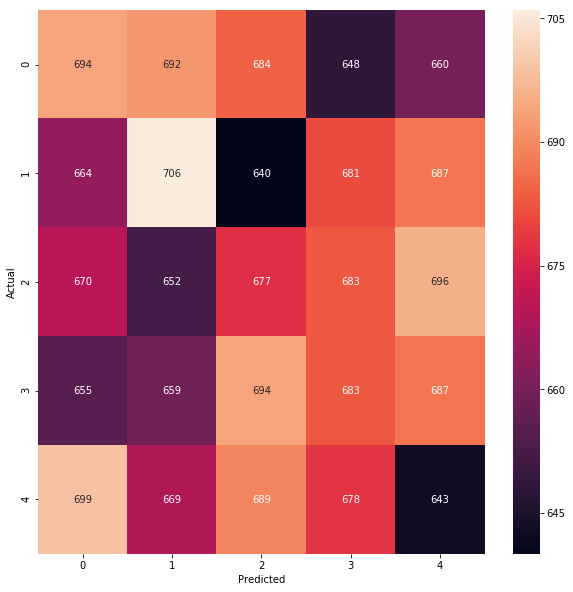

---
sklearn.neighbors.regression.KNeighborsRegressor
................................................................................
09:01:11 Still training step 80 of 563
................................................................................
09:01:13 Still training step 160 of 563
................................................................................
09:01:14 Still training step 240 of 563
................................................................................
09:01:16 Still training step 320 of 563
................................................................................
09:01:17 Still training step 400 of 563
................................................................................
09:01:19 Still training step 480 of 563
................................................................................
09:01:21 Still training step 560 of 563
...
Mean return: 2.146%
Monthly Sharpe ratio: 0.425
MSE across all predictions: 43.9342
Variance: 39.

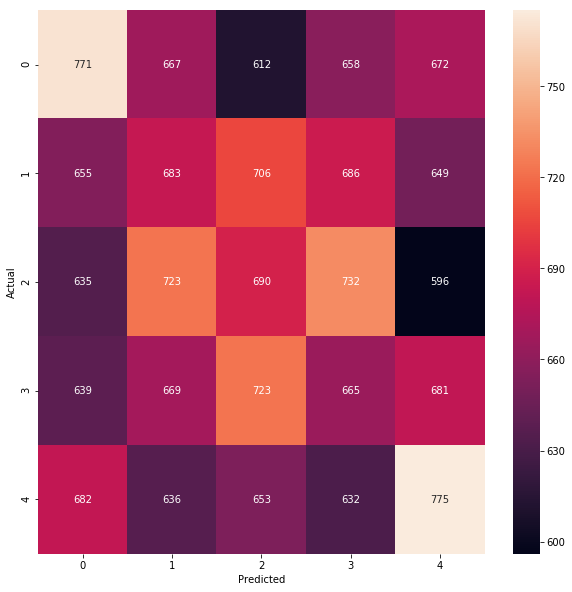

---
sklearn.svm.classes.LinearSVR
................................................................................
09:01:41 Still training step 80 of 563
................................................................................
09:02:11 Still training step 160 of 563
................................................................................
09:02:51 Still training step 240 of 563
................................................................................
09:03:43 Still training step 320 of 563
................................................................................
09:04:46 Still training step 400 of 563
................................................................................
09:06:01 Still training step 480 of 563
................................................................................
09:07:30 Still training step 560 of 563
...
Mean return: 1.021%
Monthly Sharpe ratio: 0.222
MSE across all predictions: 45.3541
Variance: 39.4097
R-squared: -0.

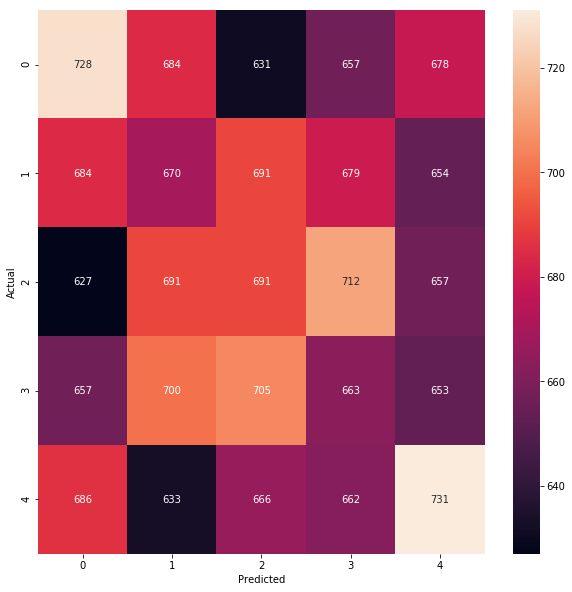

---
sklearn.svm.classes.NuSVR
................................................................................
09:07:40 Still training step 80 of 563
................................................................................
09:07:52 Still training step 160 of 563
................................................................................
09:08:12 Still training step 240 of 563
................................................................................
09:08:42 Still training step 320 of 563
................................................................................
09:09:25 Still training step 400 of 563
................................................................................
09:10:24 Still training step 480 of 563
................................................................................
09:11:41 Still training step 560 of 563
...
Mean return: -0.893%
Monthly Sharpe ratio: -0.155
MSE across all predictions: 39.8554
Variance: 39.4097
R-squared: -0.01

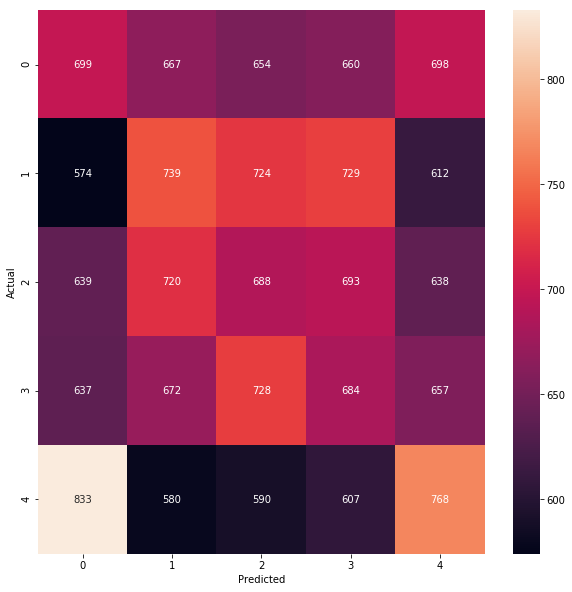

---
sklearn.svm.classes.SVR
................................................................................
09:11:51 Still training step 80 of 563
................................................................................
09:12:03 Still training step 160 of 563
................................................................................
09:12:25 Still training step 240 of 563
................................................................................
09:12:57 Still training step 320 of 563
................................................................................
09:13:44 Still training step 400 of 563
................................................................................
09:14:48 Still training step 480 of 563
................................................................................
09:16:12 Still training step 560 of 563
...
Mean return: -0.596%
Monthly Sharpe ratio: -0.074
MSE across all predictions: 39.8821
Variance: 39.4097
R-squared: -0.0120

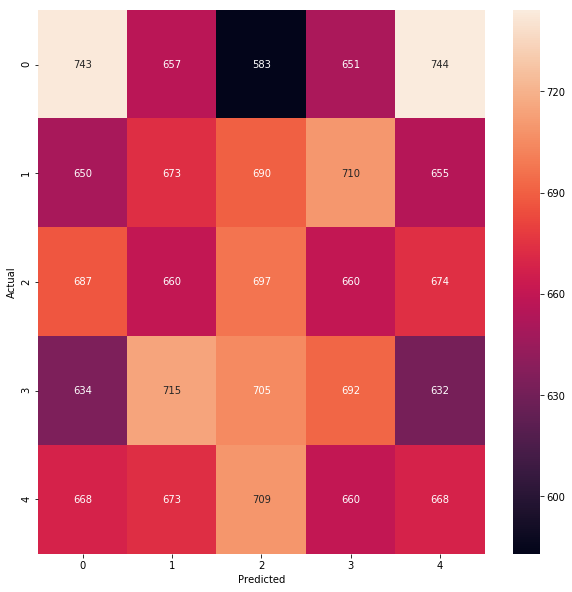

---
sklearn.tree.tree.DecisionTreeRegressor
................................................................................
09:16:23 Still training step 80 of 563
................................................................................
09:16:33 Still training step 160 of 563
................................................................................
09:16:47 Still training step 240 of 563
................................................................................
09:17:06 Still training step 320 of 563
................................................................................
09:17:30 Still training step 400 of 563
................................................................................
09:18:02 Still training step 480 of 563
................................................................................
09:18:43 Still training step 560 of 563
...
Mean return: 0.372%
Monthly Sharpe ratio: 0.102
MSE across all predictions: 83.1228
Variance: 39.4097
R-sq

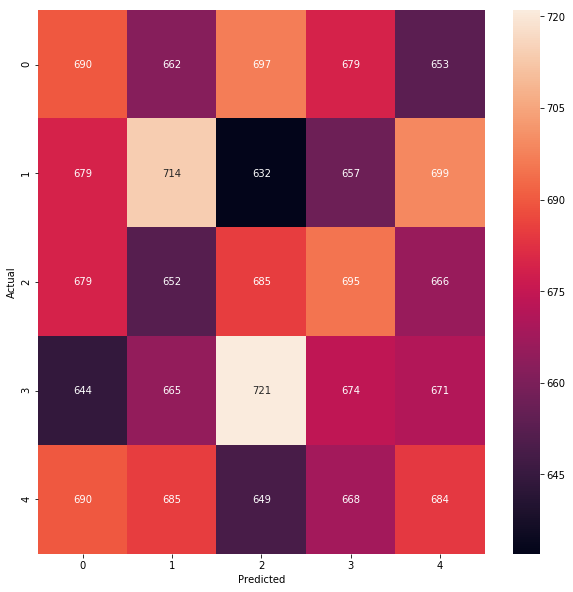

---
sklearn.tree.tree.ExtraTreeRegressor
................................................................................
09:18:48 Still training step 80 of 563
................................................................................
09:18:51 Still training step 160 of 563
................................................................................
09:18:55 Still training step 240 of 563
................................................................................
09:18:59 Still training step 320 of 563
................................................................................
09:19:05 Still training step 400 of 563
................................................................................
09:19:11 Still training step 480 of 563
................................................................................
09:19:19 Still training step 560 of 563
...
Mean return: 1.646%
Monthly Sharpe ratio: 0.385
MSE across all predictions: 79.8997
Variance: 39.4097
R-squar

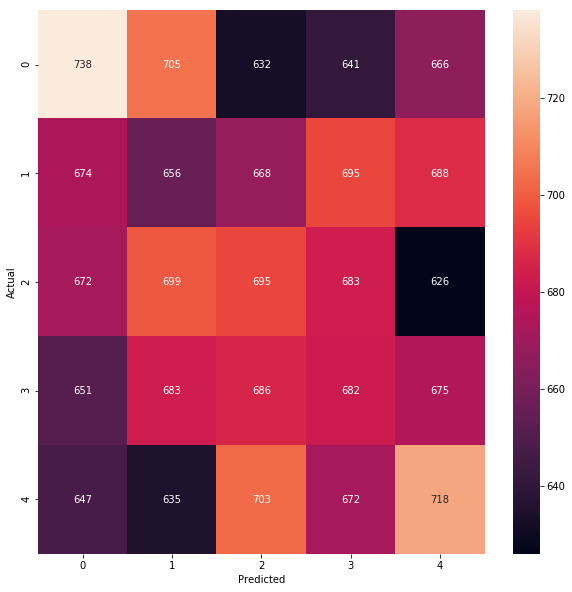

---
xgboost.sklearn.XGBRegressor
................................................................................
09:20:25 Still training step 80 of 563
................................................................................
09:21:50 Still training step 160 of 563
................................................................................
09:23:36 Still training step 240 of 563
................................................................................
09:25:42 Still training step 320 of 563
................................................................................
09:28:10 Still training step 400 of 563
................................................................................
09:30:58 Still training step 480 of 563
................................................................................
09:34:05 Still training step 560 of 563
...
Mean return: 2.176%
Monthly Sharpe ratio: 0.451
MSE across all predictions: 45.7959
Variance: 39.4097
R-squared: -0.1

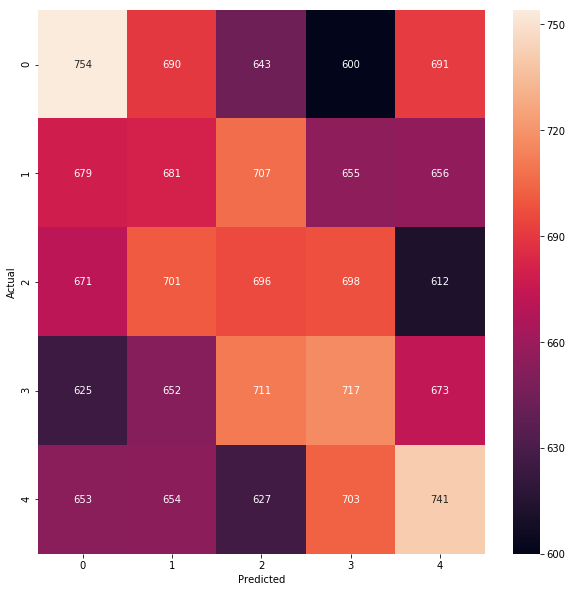

---


In [ ]:
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

for estimator in estimators:
    print(str(estimator)[8:-2])
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=True, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")

    

In [ ]:
# make a dataframe with all the metrics
est_names = [str(estimator)[8:-2] for estimator in estimators]

skmetricsframe = pd.DataFrame(list(zip(est_names, mse_list, sharpe_list, quintile_accuracy_list, directional_accuracy_list,
                                     kendalltau_list, excess_tp_list)), columns = ['name', 'mse', 'sharpe', 'quantile_score', 
                                                                                   'direction_score', 'kendalltau', 
                                                                                   'truepositive_score'])

skmetricsframe.to_csv("sklearn_metrics.csv")

In [192]:
skmetricsframe = pd.read_csv("sklearn_metrics.csv")

skmetricsframe

# find good model, tune it 
# run with lasso
# run scatter charts
# highlight linear
# write up

In [202]:
# SGDRegressor diverged to 6.309236364118325e+23
mse_list = skmetricsframe['mse'].values
mse_list = [x if x < 50 else np.nan for x in mse_list]
mse_list[24] = np.nan
sharpe_list = skmetricsframe['sharpe'].values
kendalltau_list  = skmetricsframe['kendalltau'].values
excess_tp_list = skmetricsframe['truepositive_score'].values
quintile_accuracy_list = skmetricsframe['quantile_score'].values
directional_accuracy_list = skmetricsframe['direction_score'].values
# exclude > 100
#mse_list[20] = np.nan
#mse_list[21] = np.nan


In [205]:
myscatter(mse_list, sharpe_list, title="Sharpe vs. MSE")
myscatter(quintile_accuracy_list, sharpe_list, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracy_list, sharpe_list, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltau_list, sharpe_list, title="Sharpe vs. Kendall's Tau")
myscatter(excess_tp_list, sharpe_list, title="Sharpe vs. True Positives")

In [213]:
import plotly
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('MSE', 'Quintile Accuracy','Direction Accuracy', "Kendall's tau"))
fig.append_trace(Scatter(
    x = mse_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=1)

fig.append_trace(Scatter(
    x = quintile_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=2)

fig.append_trace(Scatter(
    x = directional_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=1)

fig.append_trace(Scatter(
    x = kendalltau_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=2)


fig['layout'].update(height=1000, width=1000, title='Sharpe ratio scatters vs.')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [215]:
corrmatrix = metricsframe[['sharpe', 'mse',  'kendalltau', 
                           'quantile_score', 'direction_score', 'truepositive_score']].corr()
corrmatrix

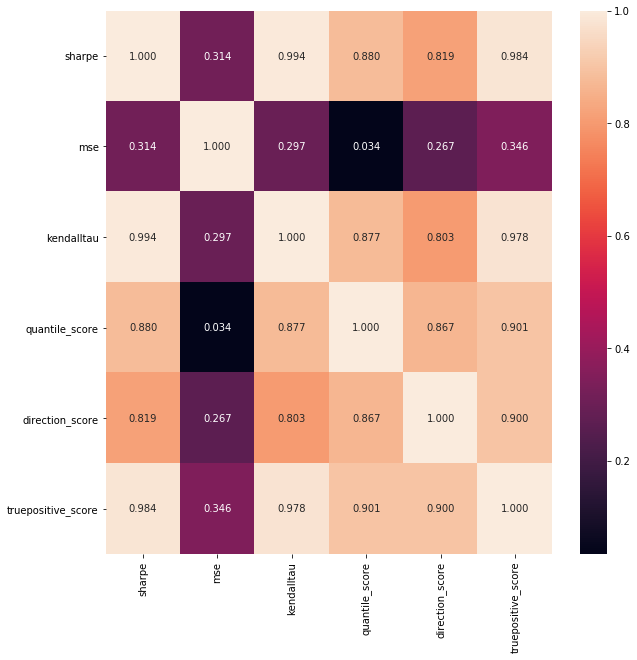

In [220]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, annot=True, fmt='.3f')
plt.show()


In [ ]:
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

def create_model(params):
    alpha, l1_ratio = params
    def myclosure():
        return sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return myclosure

alphas = [1, 3, 10, 30, 100] 
l1_ratios = [.01, .05, .1, .5, .667, .75, .9, .95, .99, 1] # 1 = LASSO, 0 = Ridge

params_list = list(product(alphas, l1_ratios))
model_list = list(map(create_model, params_list))

for i in range(len(params_list)):
    print(params_list[i])
    estimator = model_list[i]
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    #backtestmodel.walkforward_xval(n_splits=5, verbose=False)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")


(1, 0.01)
................................................................................
09:34:18 Still training step 80 of 563
................................................................................
09:34:24 Still training step 160 of 563
................................................................................
09:34:31 Still training step 240 of 563
................................................................................
09:34:39 Still training step 320 of 563
................................................................................
09:34:46 Still training step 400 of 563
................................................................................
09:34:54 Still training step 480 of 563
................................................................................
09:35:01 Still training step 560 of 563
...
Mean return: 2.797%
Monthly Sharpe ratio: 0.507
MSE across all predictions: 42.5880
Variance: 39.4097
R-squared: -0.0806
Avg rank correlatio

................................................................................
09:37:01 Still training step 80 of 563
................................................................................
09:37:02 Still training step 160 of 563
................................................................................
09:37:03 Still training step 240 of 563
................................................................................
09:37:04 Still training step 320 of 563
................................................................................
09:37:06 Still training step 400 of 563
................................................................................
09:37:07 Still training step 480 of 563
................................................................................
09:37:09 Still training step 560 of 563
...
Mean return: 3.635%
Monthly Sharpe ratio: 0.616
MSE across all predictions: 40.1591
Variance: 39.4097
R-squared: -0.0190
Avg rank correlation (Kendall

................................................................................
09:38:54 Still training step 80 of 563
................................................................................
09:38:55 Still training step 160 of 563
................................................................................
09:38:56 Still training step 240 of 563
................................................................................
09:38:57 Still training step 320 of 563
................................................................................
09:38:58 Still training step 400 of 563
................................................................................
09:38:59 Still training step 480 of 563
................................................................................
09:39:00 Still training step 560 of 563
...
Mean return: 3.248%
Monthly Sharpe ratio: 0.567
MSE across all predictions: 39.6880
Variance: 39.4097
R-squared: -0.0071
Avg rank correlation (Kendall

................................................................................
09:40:02 Still training step 80 of 563
................................................................................
09:40:04 Still training step 160 of 563
................................................................................
09:40:05 Still training step 240 of 563
................................................................................
09:40:06 Still training step 320 of 563
................................................................................
09:40:08 Still training step 400 of 563
................................................................................
09:40:10 Still training step 480 of 563
................................................................................
09:40:12 Still training step 560 of 563
...
Mean return: 3.758%
Monthly Sharpe ratio: 0.607
MSE across all predictions: 39.9170
Variance: 39.4097
R-squared: -0.0129
Avg rank correlation (Kendall

................................................................................
09:41:01 Still training step 80 of 563
................................................................................
09:41:02 Still training step 160 of 563
................................................................................
09:41:03 Still training step 240 of 563
................................................................................
09:41:04 Still training step 320 of 563
................................................................................
09:41:05 Still training step 400 of 563
................................................................................
09:41:06 Still training step 480 of 563
................................................................................
09:41:07 Still training step 560 of 563
...
Mean return: -0.958%
Monthly Sharpe ratio: -0.144
MSE across all predictions: 39.8317
Variance: 39.4097
R-squared: -0.0107
Avg rank correlation (Kenda

................................................................................
09:41:59 Still training step 80 of 563
................................................................................
09:42:00 Still training step 160 of 563
................................................................................
09:42:01 Still training step 240 of 563
................................................................................
09:42:02 Still training step 320 of 563
................................................................................
09:42:03 Still training step 400 of 563
................................................................................
09:42:04 Still training step 480 of 563
................................................................................
09:42:05 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
MSE across all predictions: 39.8418
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kenda

................................................................................
09:42:53 Still training step 80 of 563
................................................................................
09:42:54 Still training step 160 of 563
................................................................................
09:42:55 Still training step 240 of 563
................................................................................
09:42:56 Still training step 320 of 563
................................................................................
09:42:57 Still training step 400 of 563
................................................................................
09:42:58 Still training step 480 of 563
................................................................................
09:42:59 Still training step 560 of 563
...
Mean return: -1.031%
Monthly Sharpe ratio: -0.158
MSE across all predictions: 39.8371
Variance: 39.4097
R-squared: -0.0108
Avg rank correlation (Kenda

................................................................................
09:43:46 Still training step 80 of 563
................................................................................
09:43:47 Still training step 160 of 563
................................................................................
09:43:48 Still training step 240 of 563
................................................................................
09:43:49 Still training step 320 of 563
................................................................................
09:43:50 Still training step 400 of 563
................................................................................
09:43:51 Still training step 480 of 563
................................................................................
09:43:52 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
MSE across all predictions: 39.8418
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kenda

In [ ]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(params_list, mse_list, sharpe_list, 
                                                                              quintile_accuracy_list, directional_accuracy_list, kendalltau_list, excess_tp_list):
    flatlist.append([key[0], key[1], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
metricsframe = pd.DataFrame(flatlist, columns = ['alpha', 'l1_ratio',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("ElasticNetmetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]
metricsframe

In [226]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model((10, 0.1)),
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
#backtestmodel.walkforward_xval(n_splits=5, verbose=False)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    
mychart([ backtestmodel.cumulative_return, perf_LASSO_each_timestep],["ElasticNet", "LASSO/OLS"], title="ElasticNet v. LASSO/OLS")


................................................................................
18:43:23 Still training step 80 of 563
................................................................................
18:43:24 Still training step 160 of 563
................................................................................
18:43:25 Still training step 240 of 563
................................................................................
18:43:27 Still training step 320 of 563
................................................................................
18:43:28 Still training step 400 of 563
................................................................................
18:43:29 Still training step 480 of 563
................................................................................
18:43:31 Still training step 560 of 563
...
Mean return: 4.262%
Monthly Sharpe ratio: 0.695
MSE across all predictions: 39.7252
Variance: 39.4097
R-squared: -0.0080
Avg rank correlation (Kendall

In [ ]:
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

def create_model(params):
    alpha, l1_ratio = params
    def myclosure():
        return sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return myclosure

alphas = [1, 3, 10, 30, 100] 
l1_ratios = [.01, .05, .1, .5, .667, .75, .9, .95, .99, 1] # 1 = LASSO, 0 = Ridge

params_list = list(product(alphas, l1_ratios))
model_list = list(map(create_model, params_list))

for i in range(len(params_list)):
    print(params_list[i])
    estimator = model_list[i]
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="timestep", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    #backtestmodel.walkforward_xval(n_splits=5, verbose=False)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")


(1, 0.01)
................................................................................
09:44:04 Still training step 80 of 563
................................................................................
09:44:14 Still training step 160 of 563
................................................................................
09:44:28 Still training step 240 of 563
................................................................................
09:44:43 Still training step 320 of 563
................................................................................
09:44:58 Still training step 400 of 563
................................................................................
09:45:14 Still training step 480 of 563
................................................................................
09:45:30 Still training step 560 of 563
...
Mean return: 3.680%
Monthly Sharpe ratio: 0.683
MSE across all predictions: 41.0694
Variance: 39.4097
R-squared: -0.0421
Avg rank correlatio

................................................................................
09:55:15 Still training step 80 of 563
................................................................................
09:55:25 Still training step 160 of 563
................................................................................
09:55:38 Still training step 240 of 563
................................................................................
09:55:53 Still training step 320 of 563
................................................................................
09:56:08 Still training step 400 of 563
................................................................................
09:56:23 Still training step 480 of 563
................................................................................
09:56:39 Still training step 560 of 563
...
Mean return: 3.693%
Monthly Sharpe ratio: 0.644
MSE across all predictions: 40.0284
Variance: 39.4097
R-squared: -0.0157
Avg rank correlation (Kendall

................................................................................
10:06:21 Still training step 80 of 563
................................................................................
10:06:31 Still training step 160 of 563
................................................................................
10:06:44 Still training step 240 of 563
................................................................................
10:06:59 Still training step 320 of 563
................................................................................
10:07:14 Still training step 400 of 563
................................................................................
10:07:29 Still training step 480 of 563
................................................................................
10:07:44 Still training step 560 of 563
...
Mean return: 3.275%
Monthly Sharpe ratio: 0.591
MSE across all predictions: 39.6609
Variance: 39.4097
R-squared: -0.0064
Avg rank correlation (Kendall

................................................................................
10:17:21 Still training step 80 of 563
................................................................................
10:17:31 Still training step 160 of 563
................................................................................
10:17:44 Still training step 240 of 563
................................................................................
10:17:59 Still training step 320 of 563
................................................................................
10:18:14 Still training step 400 of 563
................................................................................
10:18:29 Still training step 480 of 563
................................................................................
10:18:45 Still training step 560 of 563
...
Mean return: 4.050%
Monthly Sharpe ratio: 0.701
MSE across all predictions: 39.8288
Variance: 39.4097
R-squared: -0.0106
Avg rank correlation (Kendall

................................................................................
10:28:20 Still training step 80 of 563
................................................................................
10:28:30 Still training step 160 of 563
................................................................................
10:28:43 Still training step 240 of 563
................................................................................
10:28:58 Still training step 320 of 563
................................................................................
10:29:13 Still training step 400 of 563
................................................................................
10:29:28 Still training step 480 of 563
................................................................................
10:29:43 Still training step 560 of 563
...
Mean return: -0.922%
Monthly Sharpe ratio: -0.138
MSE across all predictions: 39.8289
Variance: 39.4097
R-squared: -0.0106
Avg rank correlation (Kenda

................................................................................
10:39:18 Still training step 80 of 563
................................................................................
10:39:27 Still training step 160 of 563
................................................................................
10:39:40 Still training step 240 of 563
................................................................................
10:39:55 Still training step 320 of 563
................................................................................
10:40:10 Still training step 400 of 563
................................................................................
10:40:25 Still training step 480 of 563
................................................................................
10:40:40 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
MSE across all predictions: 39.8418
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kenda

................................................................................
10:50:14 Still training step 80 of 563
................................................................................
10:50:24 Still training step 160 of 563
................................................................................
10:50:37 Still training step 240 of 563
................................................................................
10:50:52 Still training step 320 of 563
................................................................................
10:51:07 Still training step 400 of 563
................................................................................
10:51:22 Still training step 480 of 563
................................................................................
10:51:37 Still training step 560 of 563
...
Mean return: -1.133%
Monthly Sharpe ratio: -0.177
MSE across all predictions: 39.8368
Variance: 39.4097
R-squared: -0.0108
Avg rank correlation (Kenda

................................................................................
11:01:11 Still training step 80 of 563
................................................................................
11:01:21 Still training step 160 of 563
................................................................................
11:01:34 Still training step 240 of 563
................................................................................
11:01:48 Still training step 320 of 563
................................................................................
11:02:03 Still training step 400 of 563
................................................................................
11:02:18 Still training step 480 of 563
................................................................................
11:02:33 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
MSE across all predictions: 39.8418
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kenda

In [ ]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(params_list, mse_list, sharpe_list, 
                                                                                      quintile_accuracy_list, directional_accuracy_list, kendalltau_list, excess_tp_list):
    flatlist.append([key[0], key[1], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
elasticframe2 = pd.DataFrame(flatlist, columns = ['alpha', 'l1_ratio',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

elasticframe2.to_csv("ElasticNetmetrics2.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]
elasticframe2

In [231]:
# try all the sklearn classifiers
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
<c

In [232]:
estimators

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 sklearn.ens